In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [ ]:
#Load your dataset
df = pd.read_csv("../../0_DataPreparation/initialdata/merged_data_temperature+holidays+weather_impressions.csv")

#Ensure the 'Datum' column is in datetime format
df['Datum'] = pd.to_datetime(df['Datum'])

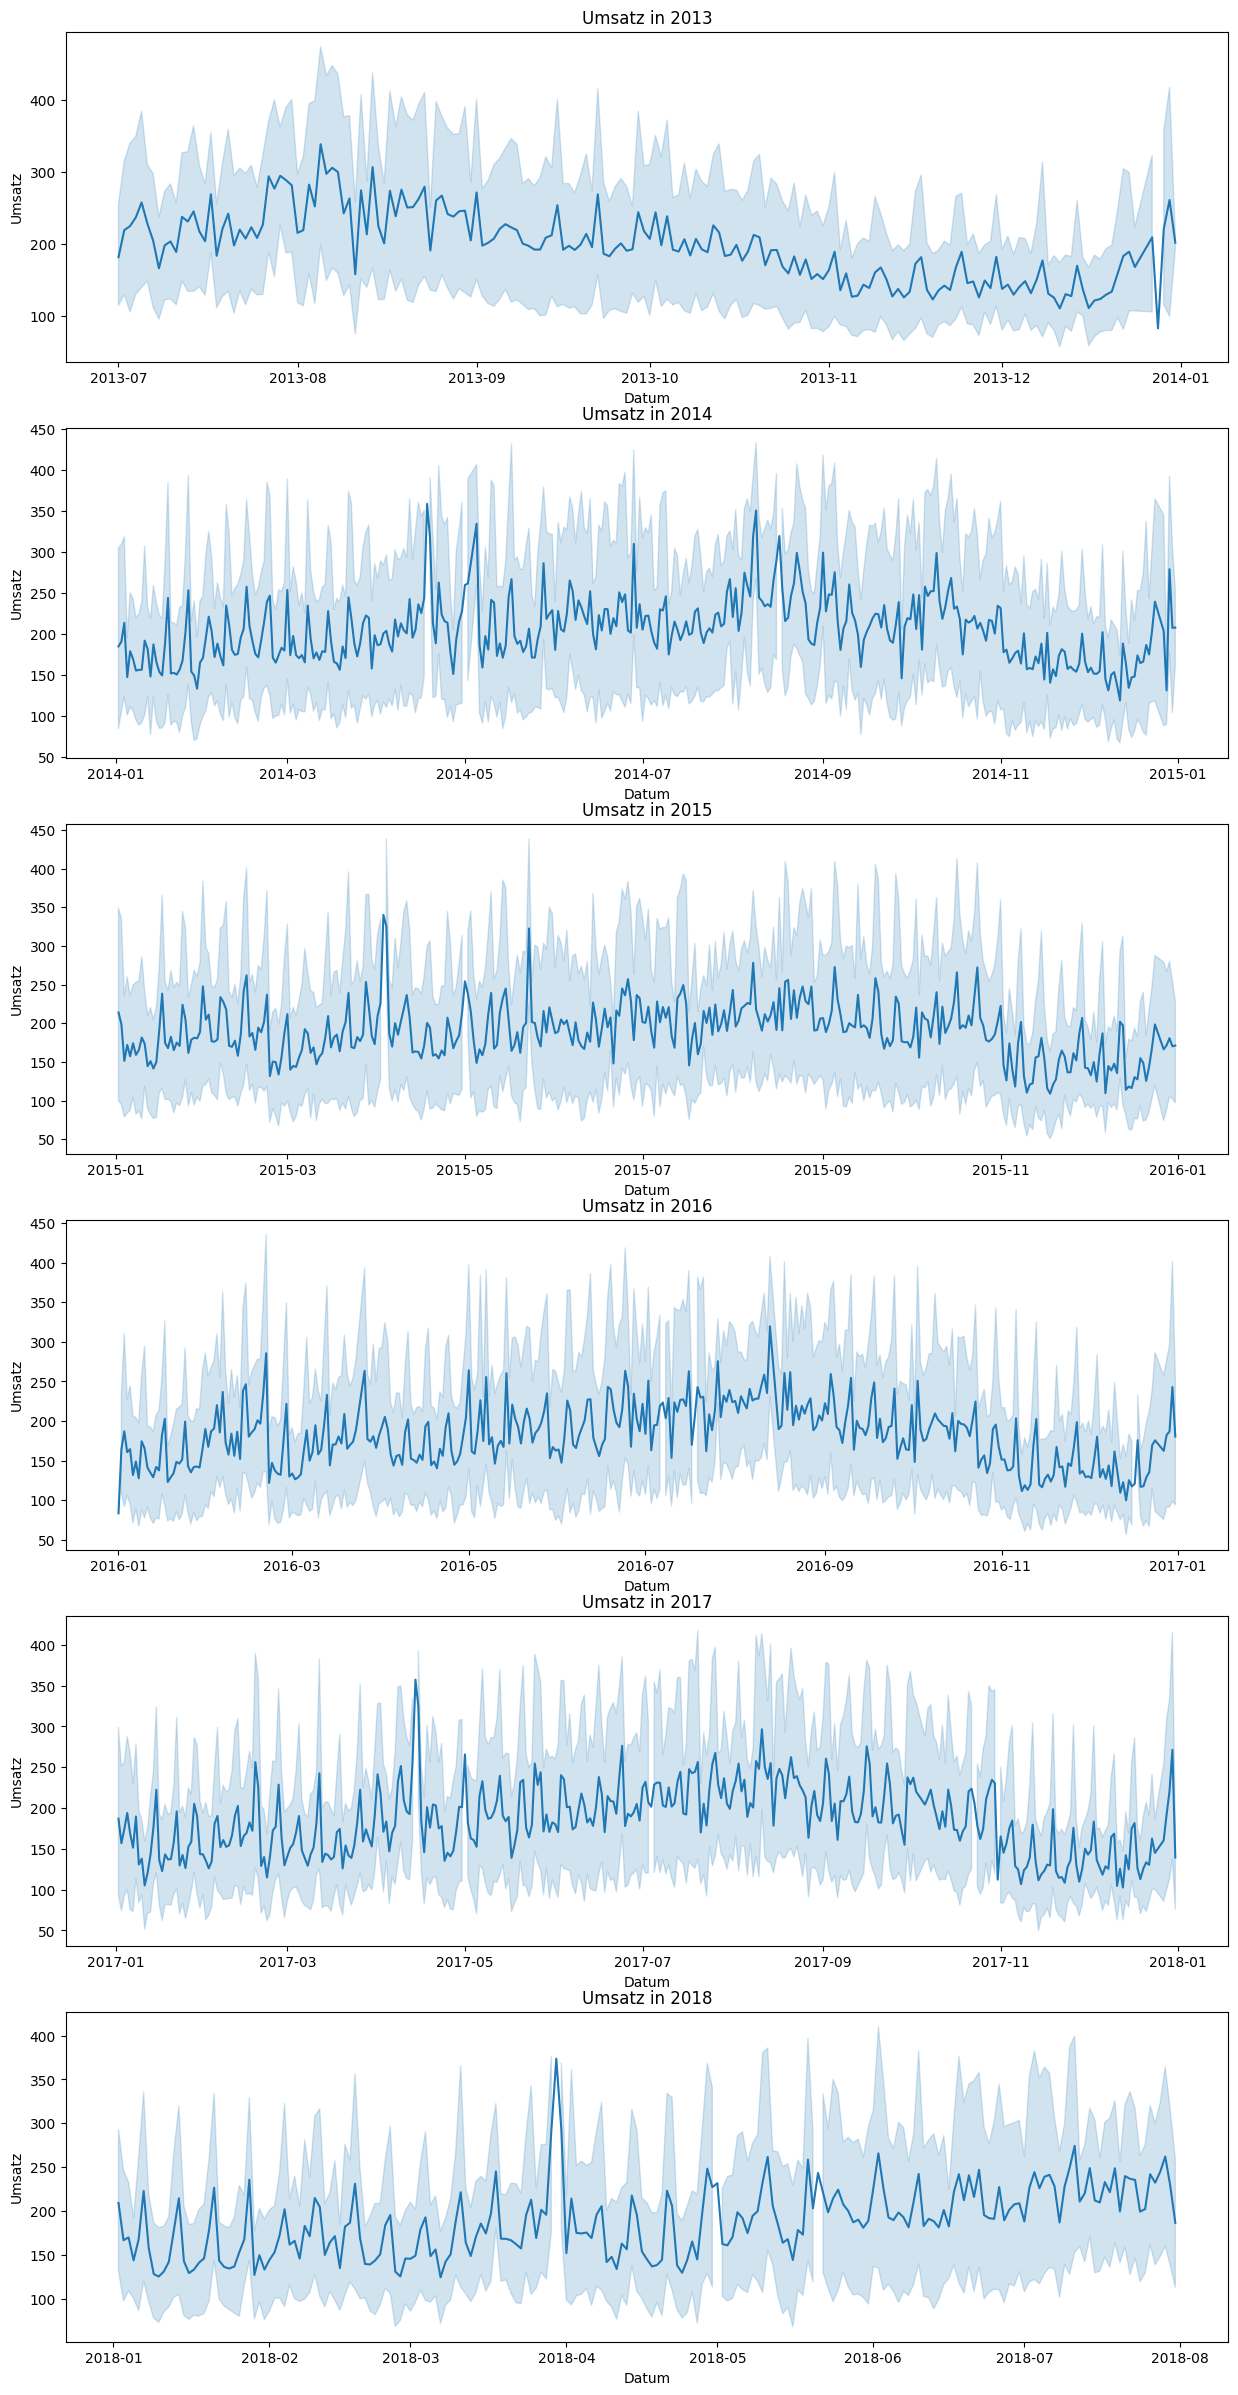

In [ ]:
df['Year'] = df['Datum'].dt.year

# Remove years 2012 and 2019
#df = df[~df['Year'].isin([2012, 2019])]

# set all values bigger than 1000 in Umsatz to nan
df.loc[df['Umsatz'] > 1000, 'Umsatz'] = np.nan

# Replace nan values with the mean of the previous and next day
nan_indices = df[df['Umsatz'].isna()].index
for idx in nan_indices:
    if idx > 0 and idx < len(df) - 1:
        df.at[idx, 'Umsatz'] = (df.at[idx - 1, 'Umsatz'] + df.at[idx + 1, 'Umsatz']) / 2
        
# Using IQR to detect and replace outliers in 'Umsatz'
Q1 = df['Umsatz'].quantile(0.25)
Q3 = df['Umsatz'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# find outliers
outlier_idx = df[(df['Umsatz'] < lower_bound) | (df['Umsatz'] > upper_bound)].index

# replace outliers with the mean of the previous and next day
for idx in outlier_idx:
    if idx > 0 and idx < len(df) - 1:
        df.at[idx, 'Umsatz'] = (df.at[idx - 1, 'Umsatz'] + df.at[idx + 1, 'Umsatz']) / 2

# create a time series plot with subplots for each year
years = sorted([year for year in df['Year'].unique() if year not in [2012, 2019]])
fig, axes = plt.subplots(len(years), 1, figsize=(15, 5 * len(years)))
for i, year in enumerate(years):
    year_data = df[df['Year'] == year]
    sns.lineplot(x='Datum', y='Umsatz', data=year_data, ax=axes[i])
    #axes[i].plot(year_data['Datum'], year_data['Umsatz'])
    axes[i].set_title(f'Umsatz in {year}')
    axes[i].set_ylabel('Umsatz')
    axes[i].set_xlabel('Datum')

In [17]:
#Define time ranges
train_start = '2013-07-01'
train_end = '2017-07-31'
val_start = '2017-08-01'
val_end = '2018-07-31'
test_start = '2018-08-01'
test_end = '2019-07-30'

#Split data
train_data = df[(df['Datum'] >= train_start) & (df['Datum'] <= train_end)]
validation_data = df[(df['Datum'] >= val_start) & (df['Datum'] <= val_end)]
test_data = df[(df['Datum'] >= test_start) & (df['Datum'] <= test_end)]

#Optional: print shapes
print("Train shape:", train_data.shape)
print("Validation shape:", validation_data.shape)
print("Test shape:", test_data.shape)

Train shape: (7517, 16)
Validation shape: (1839, 16)
Test shape: (351, 16)


In [18]:
# Convert 'Datum' to datetime and extract weekday name
train_data['Datum'] = pd.to_datetime(train_data['Datum'])
train_data['Wochentag'] = train_data['Datum'].dt.day_name()

# Create dummy variables for categorical features
X = sm.add_constant(
    pd.get_dummies(train_data[["Warengruppe", "Wochentag", "Temperatur"]], 
                   drop_first=True, dtype=int)
)
Y = train_data['Umsatz']

# Drop rows with NaN values in predictors or target
valid_idx = Y.notna() & X.notna().all(axis=1)
Y_clean = Y[valid_idx]
X_clean = X[valid_idx]

# Fit linear regression model
model = sm.OLS(Y_clean, X_clean)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     1409.
Date:                Mon, 30 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:27:42   Log-Likelihood:                -41847.
No. Observations:                7497   AIC:                         8.372e+04
Df Residuals:                    7484   BIC:                         8.381e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     89

/tmp/ipykernel_1809/1331034311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Datum'] = pd.to_datetime(train_data['Datum'])
/tmp/ipykernel_1809/1331034311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Wochentag'] = train_data['Datum'].dt.day_name()


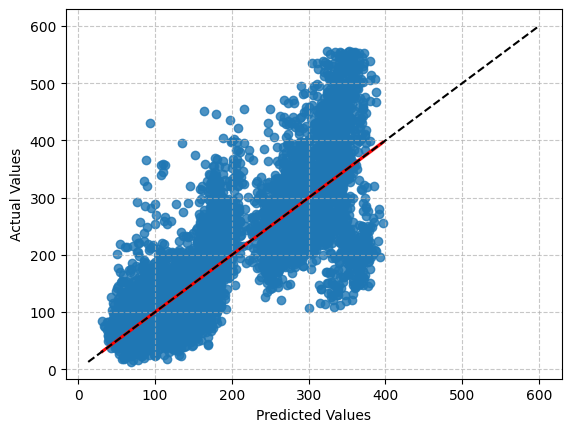

In [26]:
predicted = results.predict(X_clean)
actual = Y_clean

# Plotting the predicted vs actual values
sns.regplot(x=predicted, y=actual, line_kws={"color": "red"})
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(alpha=0.7, linestyle='--')
# adding the perfect y=x line
min = actual.min()
max = 600
plt.plot([min, max], [min, max], color='black', linestyle='--')

In [20]:
# Load test data
test_data = pd.read_csv("../Linear_regression_Lukas/test.csv")
test_data['Datum'] = pd.to_datetime(test_data['Datum'])

# Map numeric 'Warengruppe' codes to product names
warengruppe_mapping = {
    1: 'Brot',
    2: 'Brötchen',
    3: 'Croissant',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Saisonbrot'
}
test_data['Warengruppe'] = test_data['Warengruppe'].map(warengruppe_mapping)

# Define holiday dates and create 'Is_Holiday' flag
holidays = pd.to_datetime([
    # 2012–2019 holidays as in training
])
#test_data['Is_Holiday'] = test_data['Datum'].isin(holidays).astype(int)

# Add weekday name
test_data['Wochentag'] = test_data['Datum'].dt.day_name()

# Add temperature info from df
df_sliced = df[['Datum', 'Temperatur']]
df_filtered = df_sliced[df_sliced['Datum'].isin(test_data['Datum'])]
test_data = test_data.merge(df_filtered[['Datum', 'Temperatur']], on='Datum', how='left')

# find days where temperature is missing
missing_temps = test_data[test_data['Temperatur'].isna()]

# add values for missing temperatures
test_data['Temperatur'].fillna(method='ffill', inplace=True)

/tmp/ipykernel_1809/2848118790.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Temperatur'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_1809/2848118790.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data['Temperatur'].fillna(method='ffill', inplace=True)


In [21]:
# Create dummy variables for test data
X_test = pd.get_dummies(test_data[["Warengruppe", "Wochentag", "Temperatur"]], drop_first=True, dtype=int)
X_test = sm.add_constant(X_test)

# Add missing columns (from training set) to test data, filled with 0
for col in X_clean.columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Reorder columns to match training data
X_test = X_test[X_clean.columns]

# Predict 'Umsatz' using the trained model
preds = results.predict(X_test)

In [22]:
# Prüfe, ob alle Datumswerte in beiden Datensätzen enthalten sind

train_dates = set(train_data['Datum'])
test_dates = set(test_data['Datum'])

# Datumswerte, die nur im Training, aber nicht im Test sind
only_in_train = train_dates - test_dates
print(f"Datumswerte nur im Training: {only_in_train}")

# Datumswerte, die nur im Test, aber nicht im Training sind
only_in_test = test_dates - train_dates
print(f"Datumswerte nur im Test: {only_in_test}")

# Datumswerte, die in beiden sind
in_both = train_dates & test_dates
print(f"Anzahl Datumswerte in beiden Datensätzen: {len(in_both)}")

# Prüfe auf Duplikate
print("Duplikate in train_data:", train_data['Datum'].duplicated().sum())
print("Duplikate in test_data:", test_data['Datum'].duplicated().sum())

Datumswerte nur im Training: {Timestamp('2016-10-18 00:00:00'), Timestamp('2014-08-02 00:00:00'), Timestamp('2015-07-28 00:00:00'), Timestamp('2016-01-24 00:00:00'), Timestamp('2014-11-03 00:00:00'), Timestamp('2016-05-27 00:00:00'), Timestamp('2013-08-20 00:00:00'), Timestamp('2017-02-04 00:00:00'), Timestamp('2016-08-11 00:00:00'), Timestamp('2017-04-16 00:00:00'), Timestamp('2015-05-06 00:00:00'), Timestamp('2014-09-13 00:00:00'), Timestamp('2014-02-02 00:00:00'), Timestamp('2017-06-12 00:00:00'), Timestamp('2013-09-04 00:00:00'), Timestamp('2015-05-08 00:00:00'), Timestamp('2016-06-09 00:00:00'), Timestamp('2016-12-08 00:00:00'), Timestamp('2014-05-26 00:00:00'), Timestamp('2016-12-05 00:00:00'), Timestamp('2015-10-31 00:00:00'), Timestamp('2013-10-01 00:00:00'), Timestamp('2015-06-09 00:00:00'), Timestamp('2017-07-18 00:00:00'), Timestamp('2014-12-16 00:00:00'), Timestamp('2015-07-22 00:00:00'), Timestamp('2015-04-14 00:00:00'), Timestamp('2014-06-21 00:00:00'), Timestamp('2015-09

In [23]:
# Prüfe auf NaN-Werte in X_test
print("NaN in X_test:\n", X_test.isna().sum())

# Prüfe, ob die Spalten exakt gleich sind
print("Spalten Training:", list(X_clean.columns))
print("Spalten Test:", list(X_test.columns))


NaN in X_test:
 const                     0
Temperatur                0
Warengruppe_Brötchen      0
Warengruppe_Croissant     0
Warengruppe_Konditorei    0
Warengruppe_Kuchen        0
Warengruppe_Saisonbrot    0
Wochentag_Monday          0
Wochentag_Saturday        0
Wochentag_Sunday          0
Wochentag_Thursday        0
Wochentag_Tuesday         0
Wochentag_Wednesday       0
dtype: int64
Spalten Training: ['const', 'Temperatur', 'Warengruppe_Brötchen', 'Warengruppe_Croissant', 'Warengruppe_Konditorei', 'Warengruppe_Kuchen', 'Warengruppe_Saisonbrot', 'Wochentag_Monday', 'Wochentag_Saturday', 'Wochentag_Sunday', 'Wochentag_Thursday', 'Wochentag_Tuesday', 'Wochentag_Wednesday']
Spalten Test: ['const', 'Temperatur', 'Warengruppe_Brötchen', 'Warengruppe_Croissant', 'Warengruppe_Konditorei', 'Warengruppe_Kuchen', 'Warengruppe_Saisonbrot', 'Wochentag_Monday', 'Wochentag_Saturday', 'Wochentag_Sunday', 'Wochentag_Thursday', 'Wochentag_Tuesday', 'Wochentag_Wednesday']


In [24]:
print(preds)

0       140.707917
1       150.775326
2       159.440171
3       178.495716
4       159.573037
           ...    
1825     84.178904
1826     80.341639
1827     48.314406
1828     60.916140
1829     66.357391
Length: 1830, dtype: float64


In [27]:

residuals = actual - predicted

comparison_df = pd.DataFrame({
    'Predicted': predicted,
    'Actual': actual,
    'Residuals': residuals
})
print(comparison_df.head())
print("Sum of absolute residuals:", np.sum(np.abs(residuals)))

      Predicted  Actual   Residuals
394  128.779837  148.83   20.050163
395  339.378821  535.86  196.481179
396  170.368080  201.20   30.831920
397   94.714690   65.89  -28.824690
398  282.064164  317.48   35.415836
Sum of absolute residuals: 349019.2268289562


In [28]:
# Create submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'Umsatz': preds
})
submission.to_csv("sub6.csv", index=False)